# Extra Transfer Learning with Hugging Face ViT

Fine-tune the `google/vit-base-patch32-224-in21k` checkpoint on the Cats vs Dogs subset used in the original notebook, keeping the transformer encoder frozen while adapting the classification head.

In [10]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import ConfusionMatrixDisplay
from datasets import load_dataset, concatenate_datasets
from transformers import AutoImageProcessor, ViTForImageClassification

## Hyperparameters and device

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 64
epochs = 20
learning_rate = 1e-3
img_size = 224
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Load dataset from Hugging Face

In [3]:
# Download the Cats vs Dogs dataset and take a balanced subset
hf_ds_full = load_dataset('microsoft/cats_vs_dogs')['train']
cats = hf_ds_full.filter(lambda x: x['labels'] == 0).select(range(500))
dogs = hf_ds_full.filter(lambda x: x['labels'] == 1).select(range(500))
subset = concatenate_datasets([cats, dogs]).shuffle(seed=seed)
hf_splits = subset.train_test_split(test_size=0.2, seed=seed)
hf_train = hf_splits['train']
hf_valid = hf_splits['test']
print('Train size:', len(hf_train), '| Validation size:', len(hf_valid))

Filter: 100%|██████████| 23410/23410 [00:17<00:00, 1315.65 examples/s]

Train size: 800 | Validation size: 200


## Transforms and dataset wrappers

In [4]:
# Create transforms aligned with the Hugging Face processor statistics
hf_model_name = 'google/vit-base-patch32-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(hf_model_name)

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

class HFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, index):
        sample = self.hf_dataset[int(index)]
        image = sample['image']
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = int(sample['labels'])
        return image, label

train_dataset = HFDataset(hf_train, transform=train_transforms)
valid_dataset = HFDataset(hf_valid, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print('Processor mean:', image_processor.image_mean)
print('Processor std:', image_processor.image_std)

c:\Users\stiva001\AppData\Local\anaconda3\envs\timeseries\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\stiva001\.cache\huggingface\hub\models--google--vit-base-patch32-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Fast image processor class <class 'transformers.models.vit.image_processin

Processor mean: [0.5, 0.5, 0.5]
Processor std: [0.5, 0.5, 0.5]


## Build and freeze the Hugging Face ViT

In [5]:
hf_model = ViTForImageClassification.from_pretrained(
    hf_model_name,
    num_labels=2,
    id2label={0: 'cat', 1: 'dog'},
    label2id={'cat': 0, 'dog': 1},
)

for param in hf_model.vit.parameters():
    param.requires_grad = False

hf_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, hf_model.parameters()), lr=learning_rate)
print('Trainable parameters:', sum(p.numel() for p in hf_model.parameters() if p.requires_grad))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 1538


## Training loop

In [6]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    hf_model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for batch, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = hf_model(pixel_values=images)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        acc = (logits.argmax(dim=1) == labels).float().mean()
        epoch_loss += loss.item() / len(train_loader)
        epoch_acc += acc.item() / len(train_loader)

    hf_model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = hf_model(pixel_values=images)
            logits = outputs.logits
            loss = criterion(logits, labels)
            acc = (logits.argmax(dim=1) == labels).float().mean()
            val_loss += loss.item() / len(valid_loader)
            val_acc += acc.item() / len(valid_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}/{epochs} - loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')

Epoch 1/20 - loss: 0.5331 - acc: 0.9195 - val_loss: 0.3933 - val_acc: 0.9531
Epoch 2/20 - loss: 0.3084 - acc: 0.9928 - val_loss: 0.2428 - val_acc: 0.9844
Epoch 2/20 - loss: 0.3084 - acc: 0.9928 - val_loss: 0.2428 - val_acc: 0.9844
Epoch 3/20 - loss: 0.1951 - acc: 0.9940 - val_loss: 0.1670 - val_acc: 0.9844
Epoch 3/20 - loss: 0.1951 - acc: 0.9940 - val_loss: 0.1670 - val_acc: 0.9844
Epoch 4/20 - loss: 0.1349 - acc: 0.9952 - val_loss: 0.1294 - val_acc: 0.9844
Epoch 4/20 - loss: 0.1349 - acc: 0.9952 - val_loss: 0.1294 - val_acc: 0.9844
Epoch 5/20 - loss: 0.1035 - acc: 0.9952 - val_loss: 0.1088 - val_acc: 0.9844
Epoch 5/20 - loss: 0.1035 - acc: 0.9952 - val_loss: 0.1088 - val_acc: 0.9844
Epoch 6/20 - loss: 0.0842 - acc: 0.9952 - val_loss: 0.0961 - val_acc: 0.9844
Epoch 6/20 - loss: 0.0842 - acc: 0.9952 - val_loss: 0.0961 - val_acc: 0.9844
Epoch 7/20 - loss: 0.0716 - acc: 0.9952 - val_loss: 0.0878 - val_acc: 0.9844
Epoch 7/20 - loss: 0.0716 - acc: 0.9952 - val_loss: 0.0878 - val_acc: 0.9844

## Plot training curves

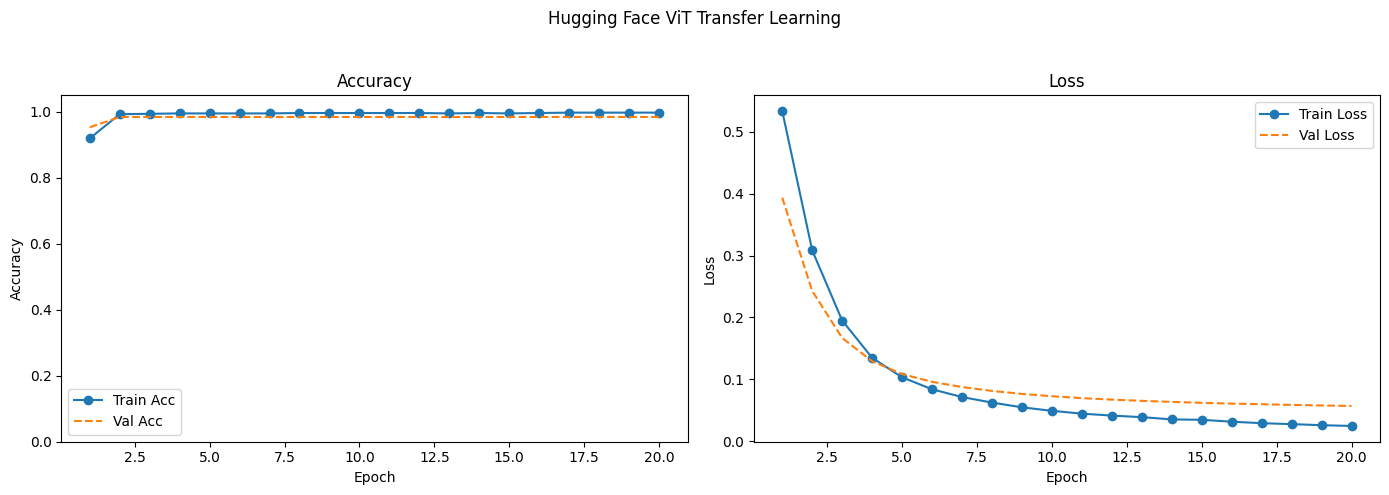

In [7]:
epochs_range = list(range(1, epochs + 1))
fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(14, 5))

ax_acc.plot(epochs_range, train_accuracies, marker='o', label='Train Acc')
ax_acc.plot(epochs_range, val_accuracies, linestyle='--', label='Val Acc')
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Accuracy')
ax_acc.set_ylim(0, 1.05)
ax_acc.set_title('Accuracy')
ax_acc.legend()

ax_loss.plot(epochs_range, train_losses, marker='o', label='Train Loss')
ax_loss.plot(epochs_range, val_losses, linestyle='--', label='Val Loss')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Loss')
ax_loss.legend()

plt.suptitle('Hugging Face ViT Transfer Learning')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Evaluation on test set

Test samples: 1000
Overall accuracy: 0.9900
Per-class accuracy: {0: np.float64(0.99), 1: np.float64(0.99)}


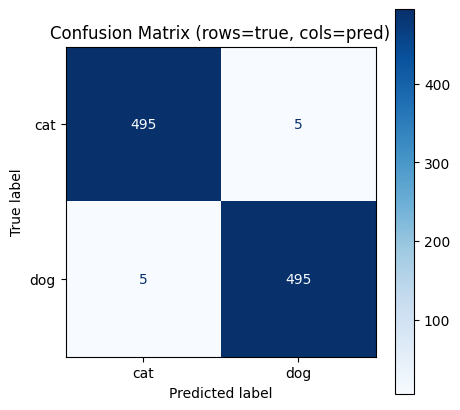

In [11]:
import numpy as np

def prepare_hf_subset(n_per_class=500):
    # uses load_dataset and concatenate_datasets already available in the notebook
    ds_full = load_dataset("microsoft/cats_vs_dogs")['train']
    cats = ds_full.filter(lambda x: x['labels'] == 0)
    dogs = ds_full.filter(lambda x: x['labels'] == 1)
    cats = cats.select(range(max(len(cats) - n_per_class, 0), len(cats)))
    dogs = dogs.select(range(max(len(dogs) - n_per_class, 0), len(dogs)))
    test_ds = concatenate_datasets([cats, dogs])
    return test_ds

# prepare test dataset and dataloader
test_hf = prepare_hf_subset(n_per_class=500)
test_dataset = HFDataset(test_hf, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# evaluate
hf_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = hf_model(pixel_values=images)
        preds = outputs.logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

accuracy = (all_preds == all_labels).mean()
# build confusion matrix
confusion = np.zeros((2, 2), dtype=int)
for t, p in zip(all_labels, all_preds):
    confusion[int(t), int(p)] += 1

per_class_acc = {}
for c in range(2):
    mask = (all_labels == c)
    per_class_acc[c] = (all_preds[mask] == c).mean() if mask.sum() > 0 else float('nan')

print(f'Test samples: {len(all_labels)}')
print(f'Overall accuracy: {accuracy:.4f}')
print('Per-class accuracy:', per_class_acc)

# plot confusion matrix using ConfusionMatrixDisplay
fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=['cat', 'dog'])
disp.plot(cmap='Blues', ax=ax_cm, values_format='d')
ax_cm.set_title('Confusion Matrix (rows=true, cols=pred)')
plt.show()

## Save the fine-tuned model

In [8]:
output_dir = 'hf_vit_b32_cats_vs_dogs'
os.makedirs(output_dir, exist_ok=True)
hf_model.save_pretrained(output_dir)
image_processor.save_pretrained(output_dir)
torch.save(hf_model.state_dict(), 'ViT_model_hf_pytorch.pt')
print('Saved model to', output_dir)
print('Saved state dict to ViT_model_hf_pytorch.pt')

Saved model to hf_vit_b32_cats_vs_dogs
Saved state dict to ViT_model_hf_pytorch.pt
